# MIE 1622 Assignment 2 (2008-2009 Data)

Name: Fendi Halim Tjoa

Student ID: 100753017

Instructor: Dr. Oleksandr Romanko 

TA: Carter Man

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math
from __future__ import print_function
import cplex
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
from matplotlib.axis import Axis  
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure
from matplotlib.ticker import ScalarFormatter
import random 
import cyipopt as ipopt
import cvxpy as cp

# Question 1


## Buy and Hold Strategy

In [2]:
# Complete the following functions
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    x_optimal = x_init
    cash_optimal = cash_init
#     print('buyhold:', x_optimal)
    return x_optimal, cash_optimal

## Equal Weight Strategy

In [3]:
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices): 
    
    # setup 
    equal_weights = np.array([1/len(x_init) for x in range(len(x_init))]) # equal weight in np.array
    portfolio_value = np.sum(x_init * cur_prices) # pure portfolio value
    total_asset = portfolio_value + cash_init
    curr_weights = x_init * cur_prices / total_asset # current portfolio weights
    x_wanted = equal_weights * total_asset / cur_prices    
    
    # calculating just the necessary buy / sell
    buy_and_sell = x_init - x_wanted # position
    sell_unit = np.where(buy_and_sell > 0, buy_and_sell, 0) # units to sell
    buy_unit = np.absolute(np.where(buy_and_sell < 0, buy_and_sell, 0)) # units to buy

    # rounding (ensure there can never be negative cash excess)
    rounded_sell_unit = np.ceil(sell_unit) # rounded top sell units. it can never sell over what we currently have
    # buy less
    rounded_buy_unit = np.floor(buy_unit * (1-0.005)**2) # buy less according to transaction fee

    # selling
    selling_transaction_fee = np.sum(rounded_sell_unit * cur_prices * (0.005)) # trans fee
    selling_value = np.sum(rounded_sell_unit * cur_prices) # no fee
    net_sell_value = selling_value - selling_transaction_fee  # money on hands after selling

    # buying
    buying_transaction_fee = np.sum(rounded_buy_unit * cur_prices * (0.005)) # trans fee
    buying_value = np.sum(rounded_buy_unit * cur_prices) # no fee
    net_buy_value = buying_transaction_fee + buying_value # cost needed to buy new assets

#     x_optimal = x_init - rounded_sell_unit + rounded_buy_unit # new asset position
    x_optimal = (x_init - rounded_sell_unit + rounded_buy_unit).astype(int) # new asset position 
    new_portfolio_value = np.sum(x_optimal * cur_prices)
    total_transaction_fee = selling_transaction_fee + buying_transaction_fee
    cash_optimal = net_sell_value - net_buy_value + cash_init
    
    
    total_transaction_fee = selling_transaction_fee + buying_transaction_fee
    new_portfolio_value = np.sum(x_optimal * cur_prices)
    
#     sanity check
#     print('eq weight:', x_optimal)
#     print(total_asset - new_portfolio_value - total_transaction_fee)
#     print(portfolio_value + cash_init - new_portfolio_value - total_transaction_fee)
#     print(net_sell_value - net_buy_value + cash_init)
#     print('weight check:', x_optimal * cur_prices / new_portfolio_value)
#     print('sum weight check:', np.sum(x_optimal * cur_prices / new_portfolio_value))
#     print('total_transaction_fee:',total_transaction_fee)

    return x_optimal, cash_optimal

## Minimum Variance Strategy

In [4]:
def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    
    n = len(x_init)
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    c = [0]*n
    ub = [1]*n
    lb = [0]*n
    
    var_names = ['w_'+str(i) for i in range(1, n+1)]
    cols = [[[0],[1]]]*n
    cpx.linear_constraints.add(rhs=[1.0], senses="E") # sum of the weights are EQUAL to 1.
    cpx.variables.add(obj = c, ub = ub, lb = lb, columns = cols,\
                    names = var_names)
    qmat = [] # 1 to 20 assets and Q covariance matrix
    for i in range(n):
        qmat.append([list(range(n)), list(2*Q[i,:])])
    cpx.objective.set_quadratic(qmat)
    
    # set CPLEX Parameters
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    
    # disable printing 
    cpx.set_warning_stream(None)
    cpx.set_results_stream(None)
    
    # solve
    cpx.solve()
    
    # optimal weights
    w_optimal = cpx.solution.get_values()
    w_optimal = np.array(w_optimal) # conver  to np array for easier calculation

#     # check negative
#     var_matr = np.diag(np.diag(Q))
#     w_minVar = w_optimal
#     var_minVar = np.dot(w_minVar, np.dot(Q, w_minVar))
#     ret_minVar = np.dot(mu, w_minVar)
#     rob_minVar = np.dot(w_minVar, np.dot(var_matr, w_minVar))

#     if ret_minVar < 0: # if portfolio return is negative, do nothing
#         x_optimal = x_init
#         cash_optimal = cash_init
#         return x_optimal, cash_optimal


    # setup
    portfolio_value = np.sum(x_init * cur_prices) # pure portfolio value
    total_asset = portfolio_value + cash_init
    curr_weights = x_init * cur_prices / total_asset # current portfolio weights
    x_wanted = w_optimal * total_asset / cur_prices
    

    # calculating just the necessary buy / sell
    buy_and_sell = x_init - x_wanted # position
    sell_unit = np.where(buy_and_sell > 0, buy_and_sell, 0) # units to sell
    buy_unit = np.absolute(np.where(buy_and_sell < 0, buy_and_sell, 0)) # units to buy
    
    # rounding (ensure there can never be negative cash excess)
    rounded_sell_unit = np.ceil(sell_unit) # rounded top sell units
    # buy less
    rounded_buy_unit = np.floor(buy_unit * (1-0.005)**2) # buy less according to transaction fee
    
    # selling
    selling_transaction_fee = np.sum(rounded_sell_unit * cur_prices * (0.005)) # trans fee
    selling_value = np.sum(rounded_sell_unit * cur_prices) # no fee
    net_sell_value = selling_value - selling_transaction_fee  # money on hands after selling

    # buying
    buying_transaction_fee = np.sum(rounded_buy_unit * cur_prices * (0.005)) # trans fee
    buying_value = np.sum(rounded_buy_unit * cur_prices) # no fee
    net_buy_value = buying_transaction_fee + buying_value # cost needed to buy new assets
    
#     x_optimal = x_init - rounded_sell_unit + rounded_buy_unit # new asset position
    x_optimal = (x_init - rounded_sell_unit + rounded_buy_unit).astype(int) # new asset position 
    new_portfolio_value = np.sum(x_optimal * cur_prices)
    total_transaction_fee = selling_transaction_fee + buying_transaction_fee
    
    cash_optimal = net_sell_value - net_buy_value + cash_init # excess cash
    
    total_transaction_fee = selling_transaction_fee + buying_transaction_fee
    new_portfolio_value = np.sum(x_optimal * cur_prices)
    
    # testing equilibrium
#     print('min var:', x_optimal)
#     print(total_asset - new_portfolio_value - total_transaction_fee)
#     print(net_sell_value - net_buy_value + cash_init)
#     print(new_portfolio_value)
#     print(portfolio_value + cash_init - total_transaction_fee)
#     print('total_transaction_fee:',total_transaction_fee)
#     print(x_optimal)
#     print(x_optimal*cur_prices/new_portfolio_value)
    return x_optimal, cash_optimal

## Maximum Sharpe Ratio Strategy

In [5]:
def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):

    Q_copy = Q.copy()
    daily_rf = r_rf2008_2009 / 252
    n = len(x_init)
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    c = [0]* (n+1) # 20 y and 1 kappa
    ub = [math.inf]* (n+1) # no limit
    lb = [0]* (n+1) 
    
    var_names = ['y_'+str(i) for i in range(1, n+1)] # 20 y variables
    var_names.append('k') # add kappa
    
    # creating constraints
    # 1) sum of y for all i = k
    # 2) sum of (mu - rf)*y for all i = 1
    cols = []
    for i in range(n):
        cols.append([[0,1],[1, mu[i] - daily_rf]]) # 20 y and mu-rf
    cols.append([[0,1],[-1,0]]) # move k to the LHS
    
    cpx.linear_constraints.add(rhs=[0, 1], senses="EE") # sum of both constraints equal to 0
    cpx.variables.add(obj = c, ub = ub, lb = lb, columns = cols,\
                    names = var_names)
#     print(np.array(mu) - daily_rf)
    
    Q = np.pad(Q, [(0, 1), (0, 1)], mode='constant', constant_values=0) # add y cov which is zeros
    
    qmat = [] # Q covariance matrix
    for i in range(n+1):
        qmat.append([list(range(n+1)), list(2*Q[i,:])])
    cpx.objective.set_quadratic(qmat)
    
    # set CPLEX Parameters
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    
    # disable printing 
    cpx.set_warning_stream(None)
    cpx.set_results_stream(None)
    
    # solve
    cpx.solve()    
    
    try:
        y_and_k = cpx.solution.get_values()

    except:
        x_optimal = x_init
        cash_optimal = cash_init
        return x_optimal, cash_optimal
    
    # optimal weights
    y_and_k = cpx.solution.get_values() # first 20 is y, last value is k
    y_and_k = np.array(y_and_k) # conver  to np array for easier calculation
    w_optimal = y_and_k[:-1] / y_and_k[-1]
    
#     print(w_optimal)
#     print(y_and_k)
#     # check negative
#     var_matr = np.diag(np.diag(Q_copy))
#     w_minVar = w_optimal
#     var_minVar = np.dot(w_minVar, np.dot(Q_copy, w_minVar))
#     ret_minVar = np.dot(mu, w_minVar)
#     rob_minVar = np.dot(w_minVar, np.dot(var_matr, w_minVar))
    
#     print(ret_minVar)
#     if ret_minVar < 0: # if portfolio return is negative, do nothing
#         x_optimal = x_init
#         cash_optimal = cash_init
#         return x_optimal, cash_optimal
    
    
    
    # setup
    portfolio_value = np.sum(x_init * cur_prices) # pure portfolio value
    total_asset = portfolio_value + cash_init
    curr_weights = x_init * cur_prices / total_asset # current portfolio weights
    x_wanted = w_optimal * total_asset / cur_prices    
    
    # calculating just the necessary buy / sell
    buy_and_sell = x_init - x_wanted # position
    sell_unit = np.where(buy_and_sell > 0, buy_and_sell, 0) # units to sell
    buy_unit = np.absolute(np.where(buy_and_sell < 0, buy_and_sell, 0)) # units to buy
    
    # rounding (ensure there can never be negative cash excess)
    rounded_sell_unit = np.ceil(sell_unit) # rounded top sell units
    # buy less
    rounded_buy_unit = np.floor(buy_unit * (1-0.005)**2) # buy less according to transaction fee
    
    # selling
    selling_transaction_fee = np.sum(rounded_sell_unit * cur_prices * (0.005)) # trans fee
    selling_value = np.sum(rounded_sell_unit * cur_prices) # no fee
    net_sell_value = selling_value - selling_transaction_fee  # money on hands after selling

    # buying
    buying_transaction_fee = np.sum(rounded_buy_unit * cur_prices * (0.005)) # trans fee
    buying_value = np.sum(rounded_buy_unit * cur_prices) # no fee
    net_buy_value = buying_transaction_fee + buying_value # cost needed to buy new assets

#     x_optimal = x_init - rounded_sell_unit + rounded_buy_unit # new asset position
    x_optimal = (x_init - rounded_sell_unit + rounded_buy_unit).astype(int) # new asset position 
    new_portfolio_value = np.sum(x_optimal * cur_prices)
    total_transaction_fee = selling_transaction_fee + buying_transaction_fee
    cash_optimal = net_sell_value - net_buy_value + cash_init # excess cash
    
    total_transaction_fee = selling_transaction_fee + buying_transaction_fee
    new_portfolio_value = np.sum(x_optimal * cur_prices)
    
    # testing equilibrium
#     print('max sharpe:', x_optimal)
#     print(total_asset - new_portfolio_value - total_transaction_fee)
#     print(net_sell_value - net_buy_value + cash_init)
#     print(new_portfolio_value)
#     print(portfolio_value + cash_init - total_transaction_fee)
    
#     print('total_transaction_fee:',total_transaction_fee)
    return x_optimal, cash_optimal

## ERC

In [6]:
def strat_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):

    n = len(x_init)
    w0 = [1.0/n] * n

    class erc(object):
        def __init__(self):
            pass

        def objective(self, x):
            # The callback for calculating the objective
            y = x * np.dot(Q, x)
            fval = 0
            for i in range(n):
                for j in range(i,n):
                    xij = y[i] - y[j]
                    fval = fval + xij*xij
            fval = 2*fval
            return fval

        def gradient(self, x):
            # The callback for calculating the gradient
            # Insert your gradient computations here
            # You can use finite differences to check the gradient
            grad = np.zeros(n)
            y = x * np.dot(Q,x)
            for i in range(n): 
                for j in range(n): 
                    for k in range(n):
                        if j != k and j<k: # excluding y_i == y_j and y_j > y_i
                            if j == i: # when y_i equals to row_i 
                                dfdx1 = np.dot(Q[j] , x) + Q[j,j] * x[j]
                                dfdx2 = Q[k,j] * x[k]
                                grad[i] = grad[i] + ((y[j] - y[k]) * (dfdx1 - dfdx2))
                            elif k == i: # when y_j equals to row_i 
                                dfdx1 = Q[j,k] * x[j]
                                dfdx2 = np.dot(Q[k], x) + Q[k,k] * x[k]
                                grad[i] = grad[i] + ((y[j] - y[k]) * (dfdx1 - dfdx2))
                            else: # when y_i is larger than row_i
                                dfdx1 = Q[j,i] * x[j]
                                dfdx2 = Q[k,i] * x[k]
                                grad[i] = grad[i] + ((y[j] - y[k]) * (dfdx1 - dfdx2))
            grad = 2*2*grad
            return grad

        def constraints(self, x):
            # The callback for calculating the constraints
            return [1.0] * n

        def jacobian(self, x):
            # The callback for calculating the Jacobian
            return np.array([[1.0] * n])

        def intermediate(
                self,
                alg_mod,
                iter_count,
                obj_value,
                inf_pr,
                inf_du,
                mu,
                d_norm,
                regularization_size,
                alpha_du,
                alpha_pr,
                ls_trials
                ):
            return
        

    lb = [0.0] * n  # lower bounds on variables
    ub = [1.0] * n  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints

    # Define IPOPT problem
    nlp = ipopt.Problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)

    # Set the IPOPT options
    nlp.add_option('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.add_option('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.add_option('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.add_option('tol'.encode('utf-8'), 1e-10)

    # Solve the problem
    w_erc, info = nlp.solve(w0)

    var_ERC = np.dot(w_erc, np.dot(Q, w_erc))
    std_ERC = np.sqrt(var_ERC)
    RC_ERC = (w_erc * np.dot(Q, w_erc)) / std_ERC

    
    w_optimal = w_erc
    w_optimal = np.array(w_optimal) # convert to np array for easier calculation

#     # check negative
#     var_matr = np.diag(np.diag(Q))
#     w_minVar = w_optimal
#     var_minVar = np.dot(w_minVar, np.dot(Q, w_minVar))
#     ret_minVar = np.dot(mu, w_minVar)
#     rob_minVar = np.dot(w_minVar, np.dot(var_matr, w_minVar))
    
# #     print(ret_minVar)
#     if ret_minVar < 0: # if portfolio return is negative, do nothing
#         x_optimal = x_init
#         cash_optimal = cash_init
#         return x_optimal, cash_optimal  
    
    
    # setup
    portfolio_value = np.sum(x_init * cur_prices) # pure portfolio value
    total_asset = portfolio_value + cash_init
    curr_weights = x_init * cur_prices / total_asset # current portfolio weights
    x_wanted = w_optimal * total_asset / cur_prices
    

    # calculating just the necessary buy / sell
    buy_and_sell = x_init - x_wanted # position
    sell_unit = np.where(buy_and_sell > 0, buy_and_sell, 0) # units to sell
    buy_unit = np.absolute(np.where(buy_and_sell < 0, buy_and_sell, 0)) # units to buy
    
    # rounding (ensure there can never be negative cash excess)
    rounded_sell_unit = np.ceil(sell_unit) # rounded top sell units
    # buy less
    rounded_buy_unit = np.floor(buy_unit * (1-0.005)**2) # buy less according to transaction fee
    
    # selling
    selling_transaction_fee = np.sum(rounded_sell_unit * cur_prices * (0.005)) # trans fee
    selling_value = np.sum(rounded_sell_unit * cur_prices) # no fee
    net_sell_value = selling_value - selling_transaction_fee  # money on hands after selling

    # buying
    buying_transaction_fee = np.sum(rounded_buy_unit * cur_prices * (0.005)) # trans fee
    buying_value = np.sum(rounded_buy_unit * cur_prices) # no fee
    net_buy_value = buying_transaction_fee + buying_value # cost needed to buy new assets
    
#     x_optimal = x_init - rounded_sell_unit + rounded_buy_unit # new asset position
    x_optimal = (x_init - rounded_sell_unit + rounded_buy_unit).astype(int) # new asset position 
    new_portfolio_value = np.sum(x_optimal * cur_prices)
    total_transaction_fee = selling_transaction_fee + buying_transaction_fee
    
    cash_optimal = net_sell_value - net_buy_value + cash_init # excess cash
    
    total_transaction_fee = selling_transaction_fee + buying_transaction_fee
    new_portfolio_value = np.sum(x_optimal * cur_prices)
#     print(cash_optimal)
    
    
    return x_optimal, cash_optimal

## Lever ERC

In [7]:
def strat_lever_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):

    n = len(x_init)
    w0 = [1.0/n] * n
    
    class erc(object):
        def __init__(self):
            pass

        def objective(self, x):
            # The callback for calculating the objective
            y = x * np.dot(Q, x)
            fval = 0
            for i in range(n):
                for j in range(i,n):
                    xij = y[i] - y[j]
                    fval = fval + xij*xij
            fval = 2*fval
            return fval

        def gradient(self, x):
            # The callback for calculating the gradient
            # Insert your gradient computations here
            # You can use finite differences to check the gradient
            grad = np.zeros(n)
            y = x * np.dot(Q,x)
            for i in range(n): 
                for j in range(n): 
                    for k in range(n):
                        if j != k and j<k: # excluding y_i == y_j and y_j > y_i
                            if j == i: # when y_i equals to row_i 
                                dfdx1 = np.dot(Q[j] , x) + Q[j,j] * x[j]
                                dfdx2 = Q[k,j] * x[k]
                                grad[i] = grad[i] + ((y[j] - y[k]) * (dfdx1 - dfdx2))
                            elif k == i: # when y_j equals to row_i 
                                dfdx1 = Q[j,k] * x[j]
                                dfdx2 = np.dot(Q[k], x) + Q[k,k] * x[k]
                                grad[i] = grad[i] + ((y[j] - y[k]) * (dfdx1 - dfdx2))
                            else: # when y_i is larger than row_i
                                dfdx1 = Q[j,i] * x[j]
                                dfdx2 = Q[k,i] * x[k]
                                grad[i] = grad[i] + ((y[j] - y[k]) * (dfdx1 - dfdx2))
            grad = 2*2*grad
            return grad

        def constraints(self, x):
            # The callback for calculating the constraints
            return [1.0] * n

        def jacobian(self, x):
            # The callback for calculating the Jacobian
            return np.array([[1.0] * n])

        def intermediate(
                self,
                alg_mod,
                iter_count,
                obj_value,
                inf_pr,
                inf_du,
                mu,
                d_norm,
                regularization_size,
                alpha_du,
                alpha_pr,
                ls_trials
                ):
            return
        

    lb = [0.0] * n  # lower bounds on variables
    ub = [1.0] * n  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints

    # Define IPOPT problem
    nlp = ipopt.Problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)

    # Set the IPOPT options
    nlp.add_option('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.add_option('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.add_option('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.add_option('tol'.encode('utf-8'), 1e-10)

    # Solve the problem
    w_erc, info = nlp.solve(w0)
    
    w_optimal = w_erc
    w_optimal = np.array(w_optimal) # convert to np array for easier calculation    
    
#     # check negative
#     var_matr = np.diag(np.diag(Q))
#     w_minVar = w_optimal
#     var_minVar = np.dot(w_minVar, np.dot(Q, w_minVar))
#     ret_minVar = np.dot(mu, w_minVar)
#     rob_minVar = np.dot(w_minVar, np.dot(var_matr, w_minVar))
    
# #     print(ret_minVar)
#     if ret_minVar < 0: # if portfolio return is negative, do nothing
#         x_optimal = x_init
#         cash_optimal = cash_init
#         return x_optimal, cash_optimal  
    
    # setup
    portfolio_value = np.sum(x_init * cur_prices) # pure portfolio value
    total_asset = portfolio_value + cash_init
    
    # leverage setup
    cash_borrowed = init_value
    period_interest = cash_borrowed * (r_rf2008_2009/6) # init_value is the cash_borrowed
    if period == 1:
        total_asset = total_asset + cash_borrowed # total asset is bigger now
    
    curr_weights = x_init * cur_prices / total_asset # current portfolio weights
    x_wanted = w_optimal * (total_asset-period_interest) / cur_prices # modified x_wanted according to interest

    # calculating just the necessary buy / sell
    buy_and_sell = x_init - x_wanted # position
    sell_unit = np.where(buy_and_sell > 0, buy_and_sell, 0) # units to sell
    buy_unit = np.absolute(np.where(buy_and_sell < 0, buy_and_sell, 0)) # units to buy
    
    # rounding (ensure there can never be negative cash excess)
    rounded_sell_unit = np.ceil(sell_unit) # rounded top sell units
    # buy less
    rounded_buy_unit = np.floor(buy_unit * ((1-0.005)**2))
    
    # selling
    selling_transaction_fee = np.sum(rounded_sell_unit * cur_prices * (0.005)) # trans fee
    selling_value = np.sum(rounded_sell_unit * cur_prices) # no fee
    net_sell_value = selling_value - selling_transaction_fee  # money on hands after selling
#     print('net_sell_value:', net_sell_value)
    
    # buying
    buying_transaction_fee = np.sum(rounded_buy_unit * cur_prices * (0.005)) # trans fee
    buying_value = np.sum(rounded_buy_unit * cur_prices) # no fee
    net_buy_value = buying_transaction_fee + buying_value # cost needed to buy new assets
#     print('net_buy_value:', net_buy_value)
    
#     x_optimal = x_init - rounded_sell_unit + rounded_buy_unit # new asset position
    x_optimal = (x_init - rounded_sell_unit + rounded_buy_unit).astype(int) # new asset position 
    new_portfolio_value = np.sum(x_optimal * cur_prices)
    total_transaction_fee = selling_transaction_fee + buying_transaction_fee
    
    if period == 1:
        cash_optimal = cash_borrowed + net_sell_value - net_buy_value + cash_init - period_interest  # excess cash
#     elif period == 12:
#         cash_optimal = net_sell_value - net_buy_value + cash_init - period_interest - cash_borrowed
    else:
        cash_optimal = net_sell_value - net_buy_value + cash_init - period_interest  # excess cash
    
    total_transaction_fee = selling_transaction_fee + buying_transaction_fee
    new_portfolio_value = np.sum(x_optimal * cur_prices)    
#     print('cash_optimal:',cash_optimal)
#     print('check total weight:', np.dot(x_optimal, cur_prices)/new_portfolio_value)
    
    weight_optimal = x_optimal * cur_prices / new_portfolio_value
#     print('check weight:',np.allclose(np.sum(weight_optimal),1))
    var_ERC = np.dot(weight_optimal, np.dot(Q, weight_optimal))
    std_ERC = np.sqrt(var_ERC)
    RC_ERC = (weight_optimal * np.dot(Q, weight_optimal)) / std_ERC
#     with np.printoptions(precision=6, suppress=True):
#         print("Risk contributions of assets in the ERC portfolio:\n{0}".format(RC_ERC))
    # Check that sum of risk contributions is equal to portfolio standard deviation
#     print('sum of risk contr is equal to portf std dev:',np.allclose(np.sum(RC_ERC), std_ERC))
    
    
    
    return x_optimal, cash_optimal

## Robust Mean Variance Variance Strategy
- Using 1/N target estimation error
- Using MinVar Target Return

In [8]:
def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices):

    n = len(x_init)
    w0 = [1.0/n] * n
#     daily_rf = r_rf2008_2009 / 252
    # Required portfolio robustness
    var_matr = np.diag(np.diag(Q))
    # Target portfolio return estimation error is return estimation error of 1/n portfolio
    rob_init = np.dot(w0, np.dot(var_matr, w0)) # return estimation error of initial portfolio
    rob_bnd  = rob_init # target return estimation error
    
    
    w1 = cp.Variable(n)
    prob1 = cp.Problem(cp.Minimize(cp.quad_form(w1, Q)),
                     [sum(w1) == 1,
                      w1 >= 0])
    
    # disable printing 
#     prob1.set_log_stream(None)
#     prob1.set_error_stream(None)
#     prob1.set_warning_stream(None)
#     prob1.set_results_stream(None)

    prob1.solve(solver=cp.CPLEX, verbose=False,cplex_params={"qpmethod": 6})

    w_minVar = w1.value
    var_minVar = np.dot(w_minVar, np.dot(Q, w_minVar))
    ret_minVar = np.dot(mu, w_minVar)
    rob_minVar = np.dot(w_minVar, np.dot(var_matr, w_minVar))
    
#     print(ret_minVar)
    if ret_minVar < 0: # if portfolio return is negative, do nothing
        x_optimal = x_init
        cash_optimal = cash_init
        return x_optimal, cash_optimal
    else:
        Portf_Retn = ret_minVar
    
    
    Qq_rMV = var_matr
    Qq_rMVs = np.sqrt(Qq_rMV)
    
    w2 = cp.Variable(n)
    prob2 = cp.Problem(cp.Minimize(cp.quad_form(w2, Q)),
                     [sum(w2) == 1,
                      mu.T@w2 >= Portf_Retn,
                      cp.quad_form(w2, Qq_rMV) <= rob_bnd,
                      w2 >= 0, w2 <= 1])
    # disable printing 
#     prob2.set_log_stream(None)
#     prob2.set_error_stream(None)
#     prob2.set_warning_stream(None)
#     prob2.set_results_stream(None)    
    
    prob2.solve(solver=cp.CPLEX, verbose=False)
    w_optimal = w2.value
    # setup
    portfolio_value = np.sum(x_init * cur_prices) # pure portfolio value
    total_asset = portfolio_value + cash_init
    curr_weights = x_init * cur_prices / total_asset # current portfolio weights
    x_wanted = w_optimal * total_asset / cur_prices    
    
    # calculating just the necessary buy / sell
    buy_and_sell = x_init - x_wanted # position
    sell_unit = np.where(buy_and_sell > 0, buy_and_sell, 0) # units to sell
    buy_unit = np.absolute(np.where(buy_and_sell < 0, buy_and_sell, 0)) # units to buy
    
    # rounding (ensure there can never be negative cash excess)
    rounded_sell_unit = np.ceil(sell_unit) # rounded top sell units
    # buy less
    rounded_buy_unit = np.floor(buy_unit * (1-0.005)**2) # buy less according to transaction fee
    
    # selling
    selling_transaction_fee = np.sum(rounded_sell_unit * cur_prices * (0.005)) # trans fee
    selling_value = np.sum(rounded_sell_unit * cur_prices) # no fee
    net_sell_value = selling_value - selling_transaction_fee  # money on hands after selling

    # buying
    buying_transaction_fee = np.sum(rounded_buy_unit * cur_prices * (0.005)) # trans fee
    buying_value = np.sum(rounded_buy_unit * cur_prices) # no fee
    net_buy_value = buying_transaction_fee + buying_value # cost needed to buy new assets

#     x_optimal = x_init - rounded_sell_unit + rounded_buy_unit # new asset position
    x_optimal = (x_init - rounded_sell_unit + rounded_buy_unit).astype(int) # new asset position 
    new_portfolio_value = np.sum(x_optimal * cur_prices)
    total_transaction_fee = selling_transaction_fee + buying_transaction_fee
    cash_optimal = net_sell_value - net_buy_value + cash_init # excess cash
    
    total_transaction_fee = selling_transaction_fee + buying_transaction_fee
    new_portfolio_value = np.sum(x_optimal * cur_prices)
    
    return x_optimal, cash_optimal

## Run File

In [9]:
x_optimal_list = []
start_tracker_list = []
end_tracker_list = []
case_list = []
curr_price_list = []
strategy_weight_list = []
twelve_price_list = []
portfolio_value_period_list = []
# Input file
input_file_prices = 'Daily_closing_prices20082009.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2007)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
# N_strat = 1  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

# strategy_functions = ['strat_buy_and_hold']
# strategy_names = ['Buy and Hold']
# N_strat = 1
# fh_array = [strat_buy_and_hold]


# strategy_functions = ['strat_equal_risk_contr']
# strategy_names = ['Equal Risk Contributions Portfolio']
# N_strat = 1
# fh_array = [strat_equal_risk_contr]

# strategy_functions = ['strat_lever_equal_risk_contr']
# strategy_names = ['Leveraged Equal Risk Contributions Portfolio']
# N_strat = 1
# fh_array = [strat_lever_equal_risk_contr]

# strategy_functions = ['strat_robust_optim']
# strategy_names = ['Robust Optimization Portfolio']
# N_strat = 1
# fh_array = [strat_robust_optim]

# strategy_functions = ['strat_min_variance']
# strategy_names = ['Mininum Variance Portfolio']
# N_strat = 1
# fh_array = [strat_min_variance]


portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 20:
       cur_year  = 20 + math.floor(period/7)
    else:
       cur_year  = 2008 + math.floor(period/7)

    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
    # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]

    # Execute portfolio selection strategies
    for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################

      curr_asset_value = np.sum(curr_positions * cur_prices) + curr_cash
      after_asset_value = np.sum(x[strategy, period-1] * cur_prices) + cash[strategy, period-1]
      # feasible check using asset value

      if period == 1 and strategy == 5:
        borrowed_cash = curr_asset_value
        after_asset_value =  after_asset_value - borrowed_cash # after asset value minus borrowed cash

      if after_asset_value   > curr_asset_value:
        print('ERROR! Strategy is not feasible. The difference is negative:', curr_asset_value - after_asset_value)
    #       else: # sanity check of transaction cost
    #         print('GOOD. Transaction Cost:', curr_asset_value - after_asset_value)

      # Check that cash account is >= 0
      if cash[strategy, period-1] < 0: 
        print('ERROR! Cash account is negative. Balance:', cash[strategy, period-1])
    #       else: # sanity check of excess cash
    #         print('GOOD. Excess cash:', cash[strategy, period-1])

      # Check that we can buy new portfolio subject to transaction costs
      # The condition to buy new portfolio is fulfilled inside the function. It will produce non-negative cash acc
      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      x_optimal_list.append(x[strategy, period-1]) # capturing all x_optimal for all strategy
#       print(day_ind_start)
#       print(day_ind_end)
      start_tracker_list.append(day_ind_start)
      end_tracker_list.append(day_ind_end)
      case_list.append(x[strategy, period-1])
      curr_price_list.append(cur_prices)
      strategy_weight_list.append(x[strategy, period-1] * cur_prices / np.sum(x[strategy, period-1] * cur_prices))  
      twelve_price_list.append(cur_prices)  
      portfolio_value_period_list.append(portf_value[strategy][day_ind_start][0])
    
      # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)
#    print(np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) , cash[strategy, period-1])
# Plot results
###################### Insert your code here ############################


Initial portfolio value = $ 385097.15


Period 1: start date 01/02/2008, end date 02/29/2008
  Strategy "Buy and Hold", value begin = $ 385097.15, value end = $ 325918.34
  Strategy "Equally Weighted Portfolio", value begin = $ 381651.61, value end = $ 326856.67
  Strategy "Mininum Variance Portfolio", value begin = $ 383268.36, value end = $ 327077.35
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 381265.54, value end = $ 332652.59
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 381849.86, value end = $ 329174.55
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 762451.50, value end = $ 657493.23
  Strategy "Robust Optimization Portfolio", value begin = $ 385097.15, value end = $ 325918.34

Period 2: start date 03/03/2008, end date 04/30/2008
  Strategy "Buy and Hold", value begin = $ 325807.08, value end = $ 349997.20
  Strategy "Equally Weighted Portfolio", value begin = $ 321997.63, value end = $ 354674.69
  Strategy "Mininum

CPLEX Error  1217: No solution exists.


  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 324816.44, value end = $ 314801.73
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 322212.05, value end = $ 326300.02
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 635384.37, value end = $ 643490.24
  Strategy "Robust Optimization Portfolio", value begin = $ 325851.40, value end = $ 329147.65

Period 5: start date 09/02/2008, end date 10/31/2008
  Strategy "Buy and Hold", value begin = $ 333252.73, value end = $ 274022.75
  Strategy "Equally Weighted Portfolio", value begin = $ 316532.45, value end = $ 231347.59
  Strategy "Mininum Variance Portfolio", value begin = $ 348226.70, value end = $ 268980.98
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 306068.62, value end = $ 228992.90
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 326059.87, value end = $ 241962.33
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 640134.25, v

The result is below:

1) Minimum Variance Portfolio rebalancing ranks the first by being having the highest portfolio value by the end of the period

- Strategies below have less money than what we start with

2) Equally weighted portfolio with rebalancing ranks second

3) Equal Risk Contributions Portfolio with rebalancing ranks third

4) Robust Optimization Portfolio Portfolio with rebalancing ranks fourth

5) Buy and Hold Portfolio Portfolio with rebalancing ranks fifth

6) Leveraged Equal Risk Contributions Portfolio with rebalancing ranks sixth

7) Maximum Sharpe Ratio Portfolio with rebalancing is the worst

In [10]:
694247.34 - borrowed_cash

309150.1948965454

## Plots

In [11]:
# setup 

# start day
start_only_list = start_tracker_list[::7]
# end day
end_only_list = end_tracker_list[::7]

# capturing assets per strategy
buy_hold_weight_list = case_list[::7]
equal_weight_list = case_list[1::7]
min_var_weight_list =case_list[2::7]
max_sharpe_weight_list =case_list[3::7]
equal_risk_weight_list =case_list[4::7]
lev_equal_risk_weight_list =case_list[5::7]
robust_weight_list =case_list[6::7]
portfolio_strat = [buy_hold_weight_list, equal_weight_list, min_var_weight_list, max_sharpe_weight_list, equal_risk_weight_list, robust_weight_list]

# assets price each period
price_each_period = curr_price_list[::7]

# convert list array to datetime
nice_dates = [datetime.strptime(date, '%m/%d/%Y').date() for date in dates]

In [12]:
# function to get daily portfolio value

def daily_portfolio_value(strategy):
    strategy_value_list = []
    for count, ele in enumerate(start_only_list):
#         if ele 
        if ele == min(start_only_list):
#             print('beginning')
            strategy_value_list.append(strategy[count] * data_prices[ele:end_only_list[count]])
        elif ele == max(start_only_list):
#             print('end')
            strategy_value_list.append(strategy[count] * data_prices[ele-1:max(end_only_list)+1])
        else:
#             print(count)
            strategy_value_list.append(strategy[count] * data_prices[ele-1:end_only_list[count]])
    
    strategy_sum_value_list = np.vstack(strategy_value_list)
    strategy_sum_value_list = np.sum(strategy_sum_value_list, axis = 1)
    return strategy_sum_value_list

### Daily Value Plot

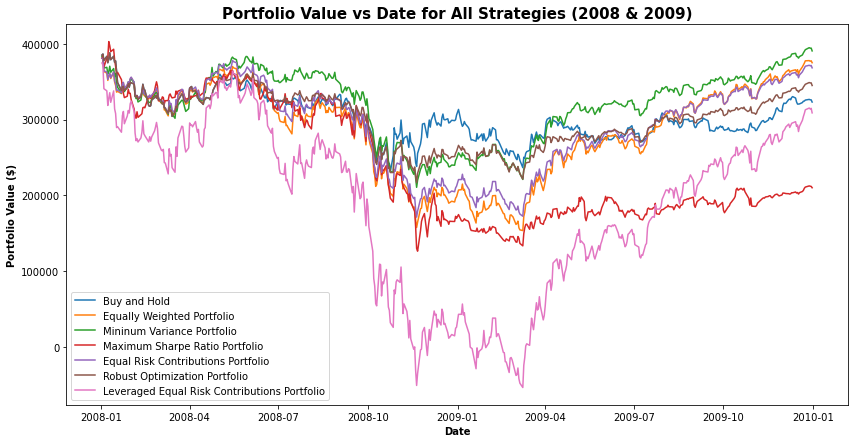

In [13]:
new_strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
fig, ax = plt.subplots(figsize=(14,7))
for count,ele in enumerate(portfolio_strat):
    ax.plot(nice_dates, daily_portfolio_value(ele), label = new_strategy_names[count])
ax.plot(nice_dates, daily_portfolio_value(lev_equal_risk_weight_list)-borrowed_cash,\
        label = 'Leveraged Equal Risk Contributions Portfolio')

plt.xlabel('Date',fontsize = 10, fontdict=dict(weight='bold'))
plt.ylabel('Portfolio Value ($)',fontsize = 10, fontdict=dict(weight='bold'))
plt.title('Portfolio Value vs Date for All Strategies (2008 & 2009)',fontsize = 15,fontdict=dict(weight='bold'))
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter)
plt.legend()
plt.show()

## Maximum Drawdown Plot

In [14]:
mdd_percent_list = []
for i in range(len(portfolio_strat)): # 7 portfolios
#     print(i)
    for j in range(12): # 12 periods
        mdd_percent_list.append((np.max(daily_portfolio_value(portfolio_strat[i])[start_only_list[j] : end_only_list[j]+1])-\
np.min(daily_portfolio_value(portfolio_strat[i])[start_only_list[j] : end_only_list[j]+1]))/ np.max(daily_portfolio_value(portfolio_strat[i])[start_only_list[j] : end_only_list[j]+1]))

In [15]:
for j in range(12):
    mdd_percent_list.append(((np.max(daily_portfolio_value(lev_equal_risk_weight_list)[start_only_list[j] : end_only_list[j]+1])-borrowed_cash) -
(np.min(daily_portfolio_value(lev_equal_risk_weight_list)[start_only_list[j] : end_only_list[j]+1])-borrowed_cash))/\
(np.max(daily_portfolio_value(lev_equal_risk_weight_list)[start_only_list[j] : end_only_list[j]+1])-borrowed_cash))

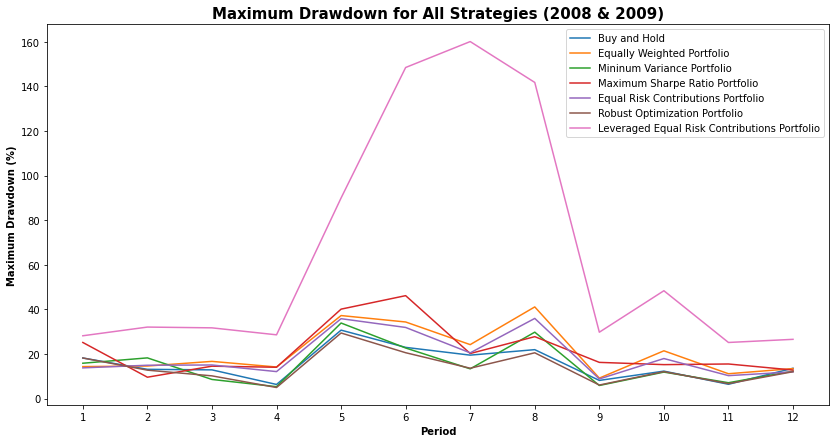

In [27]:
# new_strategy_names = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
mdd_strategy_names = new_strategy_names.copy()
mdd_strategy_names.append('Leveraged Equal Risk Contributions Portfolio')
fig, ax = plt.subplots(figsize=(14,7))
for i in range(7):
    if i == 0:
        ax.plot(np.array(mdd_percent_list[0:12])*100, label = mdd_strategy_names[i])

    else:
        plt.plot(np.array(mdd_percent_list[i*12:i*12+12])*100, label = mdd_strategy_names[i])

ax.set_xticks(range(0,12))
ax.set_xticklabels(range(1,13))
plt.xlabel('Period',fontsize = 10, fontdict=dict(weight='bold'))
plt.ylabel('Maximum Drawdown (%)',fontsize = 10, fontdict=dict(weight='bold'))
plt.title('Maximum Drawdown for All Strategies (2008 & 2009)',fontsize = 15,fontdict=dict(weight='bold'))
plt.legend()
plt.show()

## Running Maximum Drawdown Plot

In [17]:
# portfolio_value_period_list

buy_hold_value = portfolio_value_period_list[::7]
equal_weight_value = portfolio_value_period_list[1::7]
min_var_value =portfolio_value_period_list[2::7]
max_sharpe_value =portfolio_value_period_list[3::7]
equal_risk_value =portfolio_value_period_list[4::7]
lev_equal_risk_value = np.array(portfolio_value_period_list[5::7]) - borrowed_cash
robust_value =portfolio_value_period_list[6::7]

ALL_portfolio_strat = np.vstack([buy_hold_value, equal_weight_value, min_var_value, max_sharpe_value, equal_risk_value, lev_equal_risk_value, robust_value])


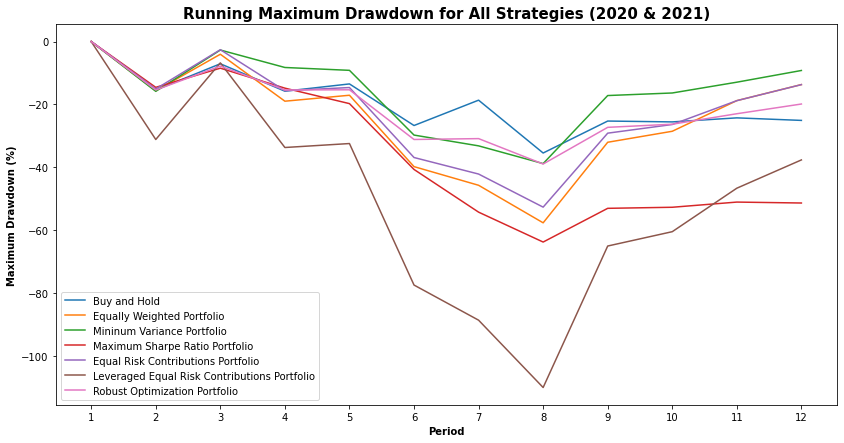

In [18]:
# new_strategy_names = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
fig, ax = plt.subplots(figsize=(14,7))
for count,ele in enumerate(ALL_portfolio_strat):
    ax.plot(((ALL_portfolio_strat[count] - np.maximum.accumulate(ALL_portfolio_strat[count])) / np.maximum.accumulate(ALL_portfolio_strat[count]))*100, label = strategy_names[count])
# ax.plot(nice_dates, daily_portfolio_value(lev_equal_risk_weight_list)-borrowed_cash,\
#         label = 'Leveraged Equal Risk Contributions Portfolio')

ax.set_xticks(range(0,12))
ax.set_xticklabels(range(1,13))
plt.xlabel('Period',fontsize = 10, fontdict=dict(weight='bold'))
plt.ylabel('Maximum Drawdown (%)',fontsize = 10, fontdict=dict(weight='bold'))
plt.title('Running Maximum Drawdown for All Strategies (2008 & 2009)',fontsize = 15,fontdict=dict(weight='bold'))
# formatter = ScalarFormatter()
# formatter.set_scientific(False)
# ax.yaxis.set_major_formatter(formatter)
plt.legend()
plt.show()

Maximum Drawdown is better if it's closer to 0 as possible. When it's 0, it means the investment didn't lose money. 

## Dynamic Change of Strategy 3 Plot (Min Var)

In [21]:
# weights of each strategy
min_var_final_weight_list = np.vstack(strategy_weight_list[2::7]).T.tolist()
max_sharpe_final_weight_list = np.vstack(strategy_weight_list[3::7]).T.tolist()
x_period = range(1,13)

In [22]:
# generating random color
random.seed(22)
number_of_colors = 20

color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]

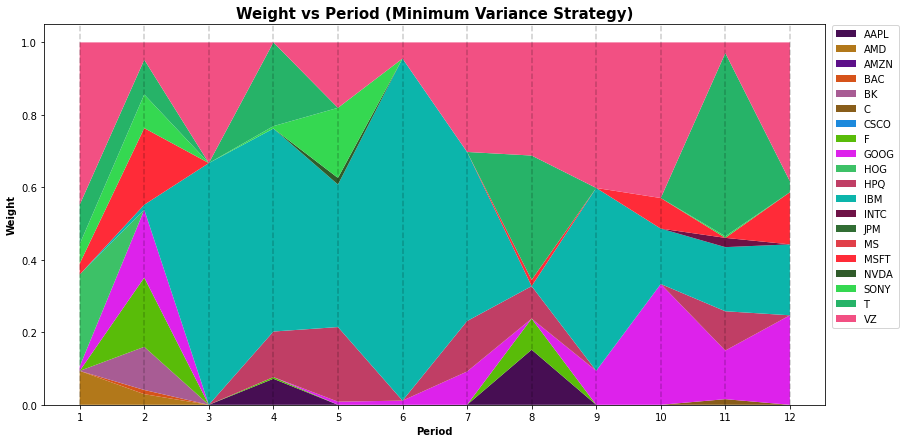

In [23]:
x_period = range(1,13)
fig, ax = plt.subplots(figsize=(14,7))

ax.stackplot(x_period, min_var_final_weight_list, labels= df.columns[1:], colors = color)
for i in x_period:
    ax.axvline(i, color ='black', linestyle = '--', alpha = 0.2)
ax.set_xticks(np.arange(1, 13, 1.0))
plt.xlabel('Period',fontsize = 10, fontdict=dict(weight='bold'))
plt.ylabel('Weight',fontsize = 10, fontdict=dict(weight='bold'))
plt.title('Weight vs Period (Minimum Variance Strategy)',fontsize = 15,fontdict=dict(weight='bold'))
ax.legend(bbox_to_anchor=(1.1, 1.01))
plt.show()




## Dynamic Change of Strategy 4 Plot (Max Sharpe)

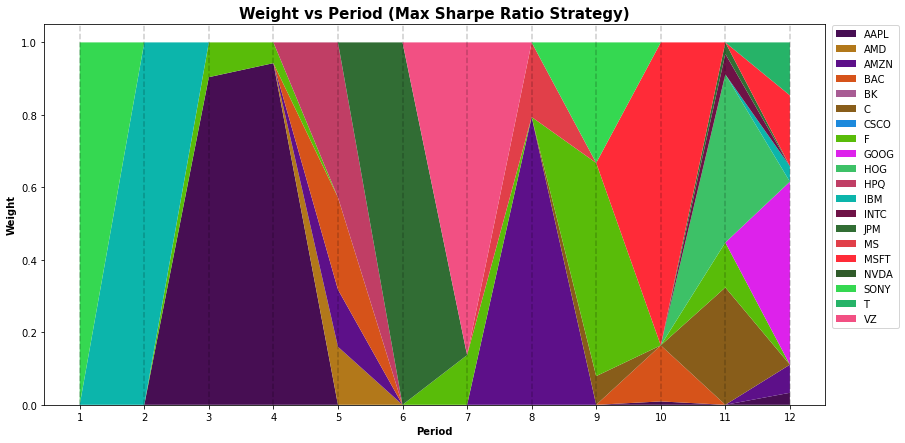

In [24]:
x_period = range(1,13)
fig, ax = plt.subplots(figsize=(14,7))

ax.stackplot(x_period, max_sharpe_final_weight_list, labels= df.columns[1:], colors = color)
for i in x_period:
    ax.axvline(i, color ='black', linestyle = '--', alpha = 0.2)
ax.set_xticks(np.arange(1, 13, 1.0))
plt.xlabel('Period',fontsize = 10, fontdict=dict(weight='bold'))
plt.ylabel('Weight',fontsize = 10, fontdict=dict(weight='bold'))
plt.title('Weight vs Period (Max Sharpe Ratio Strategy)',fontsize = 15,fontdict=dict(weight='bold'))
ax.legend(bbox_to_anchor=(1.1, 1.01))
plt.show()




## Dynamic Change of Strategy 7 Plot

In [25]:
# weights of each strategy
robust_final_weight_list = np.vstack(strategy_weight_list[6::7]).T.tolist()
x_period = range(1,13)

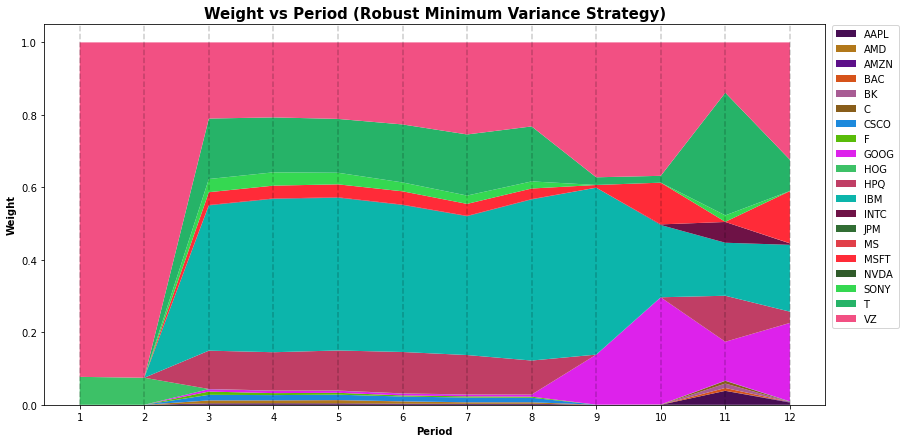

In [26]:
x_period = range(1,13)
fig, ax = plt.subplots(figsize=(14,7))

ax.stackplot(x_period, robust_final_weight_list, labels= df.columns[1:], colors = color)
for i in x_period:
    ax.axvline(i, color ='black', linestyle = '--', alpha = 0.2)
ax.set_xticks(np.arange(1, 13, 1.0))
plt.xlabel('Period',fontsize = 10, fontdict=dict(weight='bold'))
plt.ylabel('Weight',fontsize = 10, fontdict=dict(weight='bold'))
plt.title('Weight vs Period (Robust Minimum Variance Strategy)',fontsize = 15,fontdict=dict(weight='bold'))
ax.legend(bbox_to_anchor=(1.1, 1.01))
plt.show()




### Does your robust portfolio selection strategy reduce trading as compared with the strategies 3 and 4?

Yes, robust MVO strategy reduces trading as compared with strategies 3 and 4. Strategy 3 and 4 have less diversification and they often sell all asset in the beginning on each period and buy new assets. On the other hand, strategy 7 looks pretty consistent as compared to strategy 3 and 4 starting from period 3 onwards.

### Compare and discuss relative performance of your seven trading strategies during 2020-2021 and 2008-2009 time periods. Which strategy would you select for managing your own portfolio during 2008-2009 time period and why?

All the strategies have started going down since January 2008 and has a trough around March and April. All the strategies bounced back up again but they all went down and suffered a huge dip on January 2009. After that all the strategies are slowly making a comeback. As depicted on the daily plot, leveraged ERC suffered the most as it has the biggest dip compared to other strategies. Compared to 2020 – 2021 data, both leverage ERC shares the same similarities in having a huge loss during the market crashes.


1) Minimum Variance Portfolio rebalancing ranks the first by being having the highest portfolio value by the end of the period

- Strategies below have less money than what we start with

2) Equally weighted portfolio with rebalancing ranks second

3) Equal Risk Contributions Portfolio with rebalancing ranks third

4) Robust Optimization Portfolio Portfolio with rebalancing ranks fourth

5) Buy and Hold Portfolio Portfolio with rebalancing ranks fifth

6) Leveraged Equal Risk Contributions Portfolio with rebalancing ranks sixth

7) Maximum Sharpe Ratio Portfolio with rebalancing is the worst

If I were to choose which strategy to pick, my first option will be using maximum Sharpe ratio strategy with rebalancing every 2 periods. It gives almost double of what we start with, and the graph depicts that it doesn't fluctuate to below 1M at all after the 2020 market crash rebound in April. The graph also has an upward trend.

Source of 2008 market crash date: 

https://www.wealthsimple.com/en-ca/learn/2008-market-crash